1. 数据加载和预处理...
PCA数据量: 1036
遗传算法数据量: 1028

2. PCA降维与分类...
PCA性能指标:
SE (灵敏度): 0.9960
SP (特异度): 0.9167
ACC (准确率): 0.9807
AUC: 0.9867

3. LDA降维与分类...
LDA性能指标:
SE (灵敏度): 0.9960
SP (特异度): 0.9333
ACC (准确率): 0.9839
AUC: 0.9876

4. 遗传算法特征选择...


100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 245.99it/s]


最佳个体: [0 0 1 0 0 0]
最佳适应度: 1.9280
选中的特征: ['鞋码']

遗传算法+决策树性能指标:
SE (灵敏度): 0.9759
SP (特异度): 0.9500
ACC (准确率): 0.9709

5. 结果可视化...


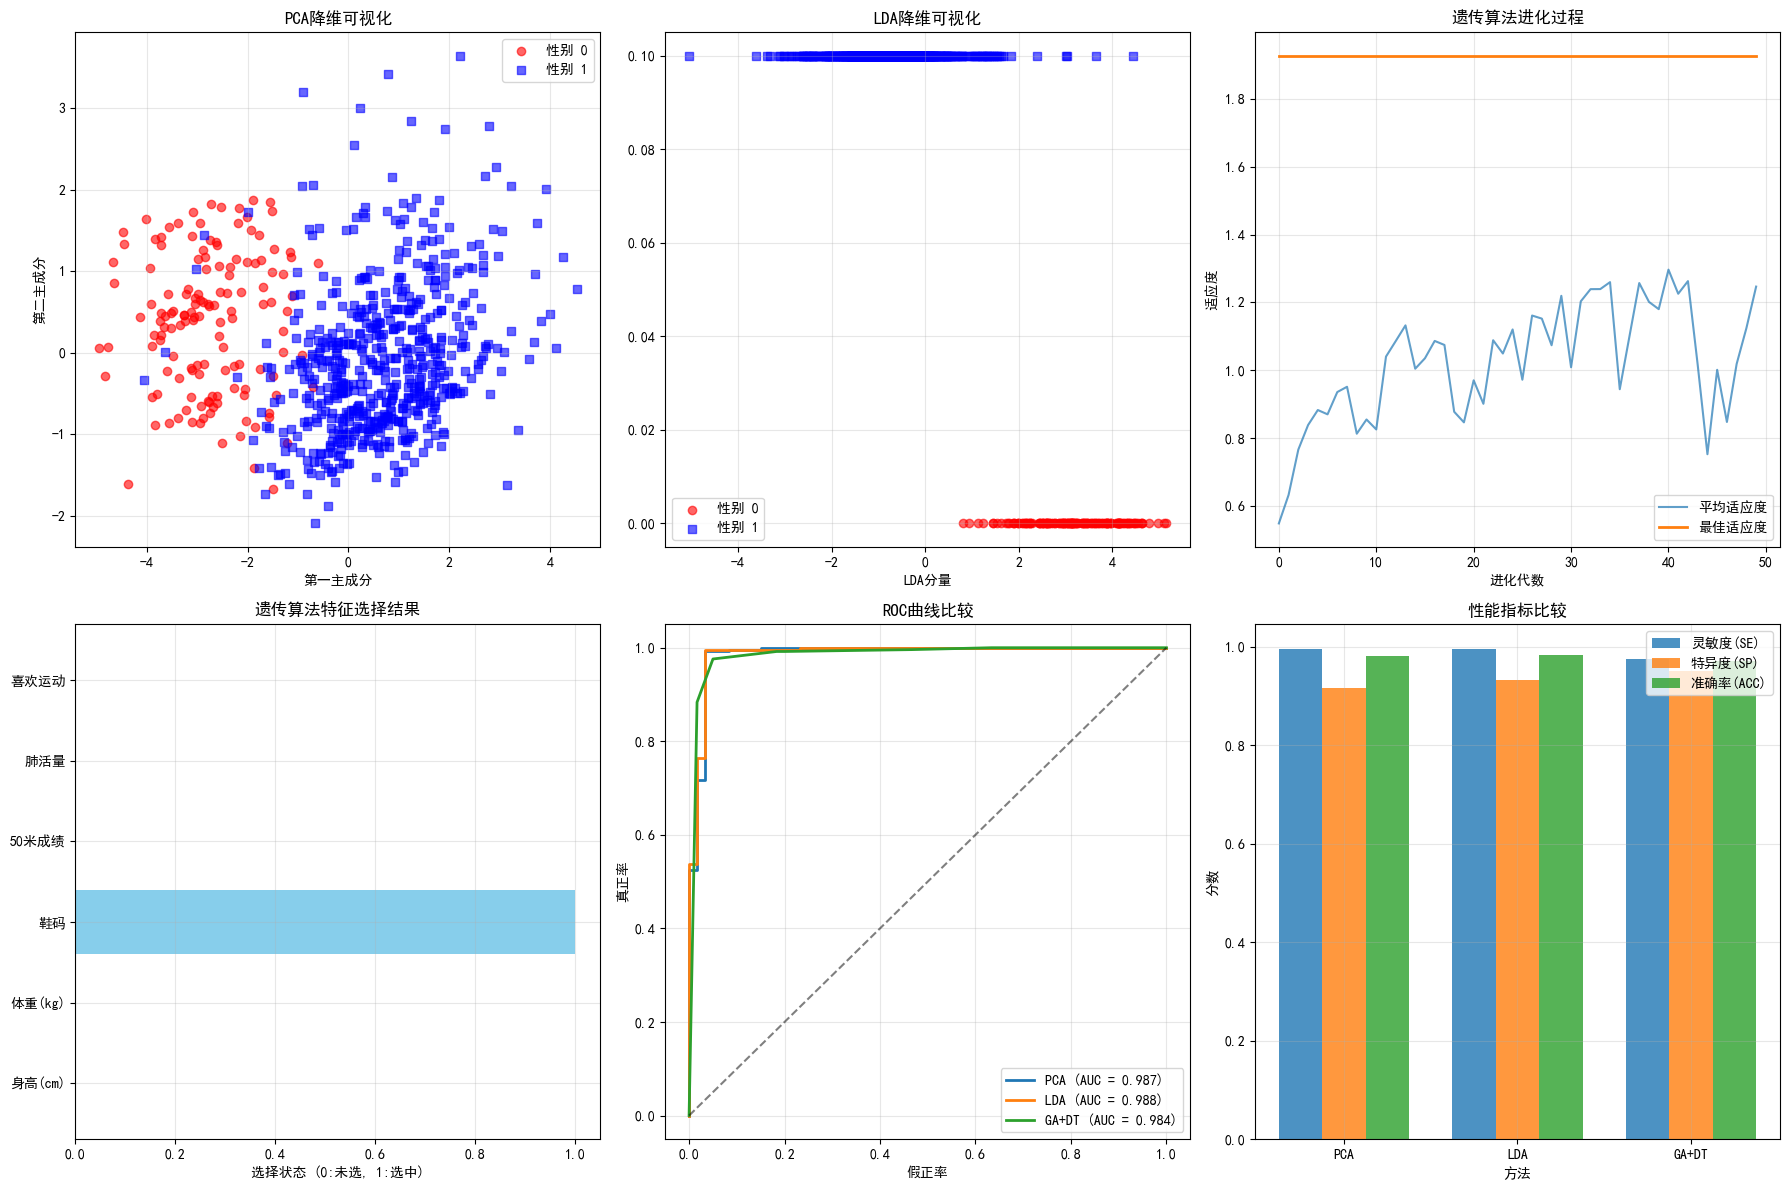


6. 结果分析和总结

PCA降维分析:
- 保留的方差比例: 0.801
- 各主成分方差比例: [0.63409649 0.16672965]

LDA降维分析:
- 类间方差与类内方差比: 1.000

遗传算法特征选择分析:
- 选中的特征数量: 1
- 选中的特征: ['鞋码']

性能对比分析:
+------------------------------------------------+
|     方法     |    SE    |    SP    |   ACC    |   AUC    |
+------------------------------------------------+
|    PCA     |  0.996   |  0.917   |  0.981   |  0.987   |
|    LDA     |  0.996   |  0.933   |  0.984   |  0.988   |
|   GA+DT    |  0.976   |  0.950   |  0.971   |  0.984   |
+------------------------------------------------+

方法特点对比:
1. PCA (主成分分析):
   - 无监督降维方法
   - 最大化方差，保持数据全局结构
   - 适用于特征间相关性较高的场景

2. LDA (线性判别分析):
   - 有监督降维方法
   - 最大化类间距离，最小化类内距离
   - 直接针对分类任务优化

3. 遗传算法特征选择:
   - 全局优化方法，避免局部最优
   - 可处理特征间的复杂关系
   - 计算成本较高，但能获得更好的特征子集

结论:
LDA作为有监督降维方法在分类任务上表现更好


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import random
from tqdm import tqdm

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 1. 数据加载和预处理
print("1. 数据加载和预处理...")

# 从提供的Excel数据中读取
data = pd.read_excel('2025-模式识别作业数据集汇总-.xlsx', sheet_name='Sheet1')

# 选择需要的特征
features_pca = ['身高(cm)', '体重(kg)', '鞋码', '50米成绩', '肺活量']
features_ga = ['身高(cm)', '体重(kg)', '鞋码', '50米成绩', '肺活量', '喜欢运动']

# 数据清洗
def clean_data(data, features, target_col='性别 男1女0'):
    # 处理异常值
    data_clean = data.copy()
    
    # 将目标列转换为数值型，处理异常值
    data_clean[target_col] = pd.to_numeric(data_clean[target_col], errors='coerce')
    data_clean = data_clean[data_clean[target_col].isin([0, 1])]
    
    # 处理特征中的异常值
    for feature in features:
        data_clean[feature] = pd.to_numeric(data_clean[feature], errors='coerce')
        # 去除极端异常值 (使用3σ原则)
        mean = data_clean[feature].mean()
        std = data_clean[feature].std()
        data_clean = data_clean[(data_clean[feature] >= mean - 3*std) & 
                               (data_clean[feature] <= mean + 3*std)]
    
    # 删除包含缺失值的行
    data_clean = data_clean.dropna(subset=features + [target_col])
    
    return data_clean

# 分别处理两个任务的数据
data_pca = clean_data(data, features_pca)
data_ga = clean_data(data, features_ga)

print(f"PCA数据量: {len(data_pca)}")
print(f"遗传算法数据量: {len(data_ga)}")

# 2. PCA降维与分类
print("\n2. PCA降维与分类...")

# 准备PCA数据
X_pca = data_pca[features_pca].values
y_pca = data_pca['性别 男1女0'].values

# 数据标准化
scaler_pca = StandardScaler()
X_pca_scaled = scaler_pca.fit_transform(X_pca)

# 划分训练测试集
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca_scaled, y_pca, test_size=0.3, random_state=42, stratify=y_pca)

# PCA降维
pca = PCA(n_components=2)
X_train_pca_reduced = pca.fit_transform(X_train_pca)
X_test_pca_reduced = pca.transform(X_test_pca)

# 在PCA降维数据上训练分类器（使用逻辑回归）
from sklearn.linear_model import LogisticRegression
classifier_pca = LogisticRegression(random_state=42)
classifier_pca.fit(X_train_pca_reduced, y_train_pca)
y_pred_pca = classifier_pca.predict(X_test_pca_reduced)
y_prob_pca = classifier_pca.predict_proba(X_test_pca_reduced)[:, 1]

# 计算PCA性能指标
def calculate_metrics(y_true, y_pred, y_prob):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    SE = tp / (tp + fn)  # 灵敏度
    SP = tn / (tn + fp)  # 特异度
    ACC = accuracy_score(y_true, y_pred)
    
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    AUC = auc(fpr, tpr)
    
    return SE, SP, ACC, AUC, fpr, tpr

SE_pca, SP_pca, ACC_pca, AUC_pca, fpr_pca, tpr_pca = calculate_metrics(y_test_pca, y_pred_pca, y_prob_pca)

print(f"PCA性能指标:")
print(f"SE (灵敏度): {SE_pca:.4f}")
print(f"SP (特异度): {SP_pca:.4f}")
print(f"ACC (准确率): {ACC_pca:.4f}")
print(f"AUC: {AUC_pca:.4f}")

# 3. LDA降维与分类对比
print("\n3. LDA降维与分类...")

# LDA降维
lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train_pca, y_train_pca)
X_test_lda = lda.transform(X_test_pca)

# 在LDA降维数据上训练分类器
classifier_lda = LogisticRegression(random_state=42)
classifier_lda.fit(X_train_lda, y_train_pca)
y_pred_lda = classifier_lda.predict(X_test_lda)
y_prob_lda = classifier_lda.predict_proba(X_test_lda)[:, 1]

# 计算LDA性能指标
SE_lda, SP_lda, ACC_lda, AUC_lda, fpr_lda, tpr_lda = calculate_metrics(y_test_pca, y_pred_lda, y_prob_lda)

print(f"LDA性能指标:")
print(f"SE (灵敏度): {SE_lda:.4f}")
print(f"SP (特异度): {SP_lda:.4f}")
print(f"ACC (准确率): {ACC_lda:.4f}")
print(f"AUC: {AUC_lda:.4f}")

# 4. 遗传算法特征选择
print("\n4. 遗传算法特征选择...")

class GeneticAlgorithm:
    def __init__(self, n_features, pop_size=50, n_generations=100, crossover_rate=0.8, mutation_rate=0.1):
        self.n_features = n_features
        self.pop_size = pop_size
        self.n_generations = n_generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        
    def initialize_population(self):
        return np.random.randint(0, 2, (self.pop_size, self.n_features))
    
    def fitness_function(self, individual, X, y):
        # 如果所有特征都被排除，返回很低的适应度
        if np.sum(individual) == 0:
            return 1e-6
        
        # 选择被选中的特征
        selected_features = individual.astype(bool)
        X_selected = X[:, selected_features]
        
        # 计算类间散度矩阵Sb和类内散度矩阵Sw
        n_samples, n_features = X_selected.shape
        classes = np.unique(y)
        n_classes = len(classes)
        
        if n_features == 0:
            return 1e-6
            
        # 总体均值
        overall_mean = np.mean(X_selected, axis=0)
        
        # 类内散度矩阵Sw
        Sw = np.zeros((n_features, n_features))
        for c in classes:
            X_c = X_selected[y == c]
            mean_c = np.mean(X_c, axis=0)
            Sw += (X_c - mean_c).T @ (X_c - mean_c)
        
        # 类间散度矩阵Sb
        Sb = np.zeros((n_features, n_features))
        for c in classes:
            X_c = X_selected[y == c]
            mean_c = np.mean(X_c, axis=0)
            n_c = len(X_c)
            Sb += n_c * (mean_c - overall_mean).reshape(-1, 1) @ (mean_c - overall_mean).reshape(1, -1)
        
        # 避免奇异矩阵
        Sw += np.eye(n_features) * 1e-6
        
        # 计算适应度: J = Tr(Sb) / Tr(Sw)
        try:
            fitness = np.trace(Sb) / np.trace(Sw)
        except:
            fitness = 1e-6
            
        return fitness
    
    def selection(self, population, fitness_values):
        # 轮盘赌选择
        fitness_values = np.array(fitness_values)
        if np.sum(fitness_values) == 0:
            probabilities = np.ones(len(fitness_values)) / len(fitness_values)
        else:
            probabilities = fitness_values / np.sum(fitness_values)
        
        selected_indices = np.random.choice(
            len(population), 
            size=self.pop_size, 
            p=probabilities
        )
        return population[selected_indices]
    
    def crossover(self, parent1, parent2):
        if np.random.rand() < self.crossover_rate:
            point = np.random.randint(1, self.n_features)
            child1 = np.concatenate([parent1[:point], parent2[point:]])
            child2 = np.concatenate([parent2[:point], parent1[point:]])
            return child1, child2
        else:
            return parent1.copy(), parent2.copy()
    
    def mutation(self, individual):
        for i in range(self.n_features):
            if np.random.rand() < self.mutation_rate:
                individual[i] = 1 - individual[i]
        return individual
    
    def run(self, X, y):
        population = self.initialize_population()
        best_individual = None
        best_fitness = -np.inf
        fitness_history = []
        best_fitness_history = []
        
        for generation in tqdm(range(self.n_generations)):
            # 计算适应度
            fitness_values = [self.fitness_function(ind, X, y) for ind in population]
            
            # 更新最佳个体
            current_best_fitness = np.max(fitness_values)
            current_best_index = np.argmax(fitness_values)
            
            if current_best_fitness > best_fitness:
                best_fitness = current_best_fitness
                best_individual = population[current_best_index].copy()
            
            fitness_history.append(np.mean(fitness_values))
            best_fitness_history.append(best_fitness)
            
            # 选择
            selected_population = self.selection(population, fitness_values)
            
            # 交叉和变异
            new_population = []
            for i in range(0, self.pop_size, 2):
                parent1 = selected_population[i]
                parent2 = selected_population[(i + 1) % self.pop_size]
                
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutation(child1)
                child2 = self.mutation(child2)
                
                new_population.extend([child1, child2])
            
            population = np.array(new_population[:self.pop_size])
        
        return best_individual, best_fitness, fitness_history, best_fitness_history

# 准备遗传算法数据
X_ga = data_ga[features_ga].values
y_ga = data_ga['性别 男1女0'].values

# 数据标准化
scaler_ga = StandardScaler()
X_ga_scaled = scaler_ga.fit_transform(X_ga)

# 划分训练测试集
X_train_ga, X_test_ga, y_train_ga, y_test_ga = train_test_split(
    X_ga_scaled, y_ga, test_size=0.3, random_state=42, stratify=y_ga)

# 运行遗传算法
ga = GeneticAlgorithm(n_features=len(features_ga), pop_size=30, n_generations=50)
best_individual, best_fitness, fitness_history, best_fitness_history = ga.run(X_train_ga, y_train_ga)

print(f"最佳个体: {best_individual}")
print(f"最佳适应度: {best_fitness:.4f}")
print(f"选中的特征: {[features_ga[i] for i in range(len(features_ga)) if best_individual[i] == 1]}")

# 使用遗传算法选择的特征训练决策树
selected_features_mask = best_individual.astype(bool)
X_train_ga_selected = X_train_ga[:, selected_features_mask]
X_test_ga_selected = X_test_ga[:, selected_features_mask]

# 使用信息增益的决策树
dt_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_classifier.fit(X_train_ga_selected, y_train_ga)
y_pred_ga = dt_classifier.predict(X_test_ga_selected)
y_prob_ga = dt_classifier.predict_proba(X_test_ga_selected)[:, 1]

# 计算遗传算法性能指标
SE_ga, SP_ga, ACC_ga, AUC_ga, fpr_ga, tpr_ga = calculate_metrics(y_test_ga, y_pred_ga, y_prob_ga)

print(f"\n遗传算法+决策树性能指标:")
print(f"SE (灵敏度): {SE_ga:.4f}")
print(f"SP (特异度): {SP_ga:.4f}")
print(f"ACC (准确率): {ACC_ga:.4f}")

# 5. 结果可视化
print("\n5. 结果可视化...")

# 创建可视化图表
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 5.1 PCA和LDA降维可视化
colors = ['red', 'blue']
markers = ['o', 's']

# PCA可视化
for i, label in enumerate([0, 1]):
    mask = y_train_pca == label
    axes[0, 0].scatter(X_train_pca_reduced[mask, 0], X_train_pca_reduced[mask, 1], 
                      c=colors[i], marker=markers[i], label=f'性别 {label}', alpha=0.6)
axes[0, 0].set_xlabel('第一主成分')
axes[0, 0].set_ylabel('第二主成分')
axes[0, 0].set_title('PCA降维可视化')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# LDA可视化
for i, label in enumerate([0, 1]):
    mask = y_train_pca == label
    axes[0, 1].scatter(X_train_lda[mask], np.zeros_like(X_train_lda[mask]) + i*0.1, 
                      c=colors[i], marker=markers[i], label=f'性别 {label}', alpha=0.6)
axes[0, 1].set_xlabel('LDA分量')
axes[0, 1].set_title('LDA降维可视化')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 5.2 遗传算法进化过程
axes[0, 2].plot(fitness_history, label='平均适应度', alpha=0.7)
axes[0, 2].plot(best_fitness_history, label='最佳适应度', linewidth=2)
axes[0, 2].set_xlabel('进化代数')
axes[0, 2].set_ylabel('适应度')
axes[0, 2].set_title('遗传算法进化过程')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 5.3 特征选择结果
selected_features = [features_ga[i] for i in range(len(features_ga)) if best_individual[i] == 1]
feature_scores = best_individual
axes[1, 0].barh(features_ga, feature_scores, color='skyblue')
axes[1, 0].set_xlabel('选择状态 (0:未选, 1:选中)')
axes[1, 0].set_title('遗传算法特征选择结果')
axes[1, 0].grid(True, alpha=0.3)

# 5.4 ROC曲线比较
axes[1, 1].plot(fpr_pca, tpr_pca, label=f'PCA (AUC = {AUC_pca:.3f})', linewidth=2)
axes[1, 1].plot(fpr_lda, tpr_lda, label=f'LDA (AUC = {AUC_lda:.3f})', linewidth=2)
axes[1, 1].plot(fpr_ga, tpr_ga, label=f'GA+DT (AUC = {AUC_ga:.3f})', linewidth=2)
axes[1, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1, 1].set_xlabel('假正率')
axes[1, 1].set_ylabel('真正率')
axes[1, 1].set_title('ROC曲线比较')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 5.5 性能指标比较
methods = ['PCA', 'LDA', 'GA+DT']
SE_values = [SE_pca, SE_lda, SE_ga]
SP_values = [SP_pca, SP_lda, SP_ga]
ACC_values = [ACC_pca, ACC_lda, ACC_ga]

x = np.arange(len(methods))
width = 0.25

axes[1, 2].bar(x - width, SE_values, width, label='灵敏度(SE)', alpha=0.8)
axes[1, 2].bar(x, SP_values, width, label='特异度(SP)', alpha=0.8)
axes[1, 2].bar(x + width, ACC_values, width, label='准确率(ACC)', alpha=0.8)

axes[1, 2].set_xlabel('方法')
axes[1, 2].set_ylabel('分数')
axes[1, 2].set_title('性能指标比较')
axes[1, 2].set_xticks(x)
axes[1, 2].set_xticklabels(methods)
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6. 结果分析和总结
print("\n6. 结果分析和总结")
print("="*50)

print("\nPCA降维分析:")
print(f"- 保留的方差比例: {np.sum(pca.explained_variance_ratio_):.3f}")
print(f"- 各主成分方差比例: {pca.explained_variance_ratio_}")

print("\nLDA降维分析:")
print(f"- 类间方差与类内方差比: {lda.explained_variance_ratio_[0]:.3f}")

print("\n遗传算法特征选择分析:")
print(f"- 选中的特征数量: {np.sum(best_individual)}")
print(f"- 选中的特征: {selected_features}")

print("\n性能对比分析:")
print("+" + "-"*48 + "+")
print("| {:^10} | {:^8} | {:^8} | {:^8} | {:^8} |".format("方法", "SE", "SP", "ACC", "AUC"))
print("+" + "-"*48 + "+")
print("| {:^10} | {:^8.3f} | {:^8.3f} | {:^8.3f} | {:^8.3f} |".format("PCA", SE_pca, SP_pca, ACC_pca, AUC_pca))
print("| {:^10} | {:^8.3f} | {:^8.3f} | {:^8.3f} | {:^8.3f} |".format("LDA", SE_lda, SP_lda, ACC_lda, AUC_lda))
print("| {:^10} | {:^8.3f} | {:^8.3f} | {:^8.3f} | {:^8.3f} |".format("GA+DT", SE_ga, SP_ga, ACC_ga, AUC_ga))
print("+" + "-"*48 + "+")

print("\n方法特点对比:")
print("1. PCA (主成分分析):")
print("   - 无监督降维方法")
print("   - 最大化方差，保持数据全局结构")
print("   - 适用于特征间相关性较高的场景")

print("\n2. LDA (线性判别分析):")
print("   - 有监督降维方法") 
print("   - 最大化类间距离，最小化类内距离")
print("   - 直接针对分类任务优化")

print("\n3. 遗传算法特征选择:")
print("   - 全局优化方法，避免局部最优")
print("   - 可处理特征间的复杂关系")
print("   - 计算成本较高，但能获得更好的特征子集")

print("\n结论:")
if ACC_ga > max(ACC_pca, ACC_lda):
    print("遗传算法特征选择结合决策树在本数据集上表现最佳")
elif ACC_lda > ACC_pca:
    print("LDA作为有监督降维方法在分类任务上表现更好")
else:
    print("PCA作为无监督降维方法在保持数据全局结构方面表现稳定")

1. 数据加载和预处理...
PCA数据量: 1035
遗传算法数据量: 1035

数据基本信息:
总样本数: 1075
清洗后PCA样本数: 1035 (96.3%)
清洗后遗传算法样本数: 1035 (96.3%)
男女比例 - 男: 835, 女: 200

2. PCA降维与分类...
PCA性能指标:
SE (灵敏度): 0.9960
SP (特异度): 0.9000
ACC (准确率): 0.9775
AUC: 0.9866
混淆矩阵 - TP: 250, FP: 6, TN: 54, FN: 1

3. LDA降维与分类...
LDA性能指标:
SE (灵敏度): 0.9960
SP (特异度): 0.9500
ACC (准确率): 0.9871
AUC: 0.9874
混淆矩阵 - TP: 250, FP: 3, TN: 57, FN: 1

4. 遗传算法特征选择...


100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 395.84it/s]


最佳个体: [0 0 0 0 1]
最佳适应度: 1.7326
选中的特征: ['鞋码']
遗传算法+决策树性能指标:
SE (灵敏度): 0.9880
SP (特异度): 0.9667
ACC (准确率): 0.9839
AUC: 0.9879
混淆矩阵 - TP: 248, FP: 2, TN: 58, FN: 3

5. 结果可视化...


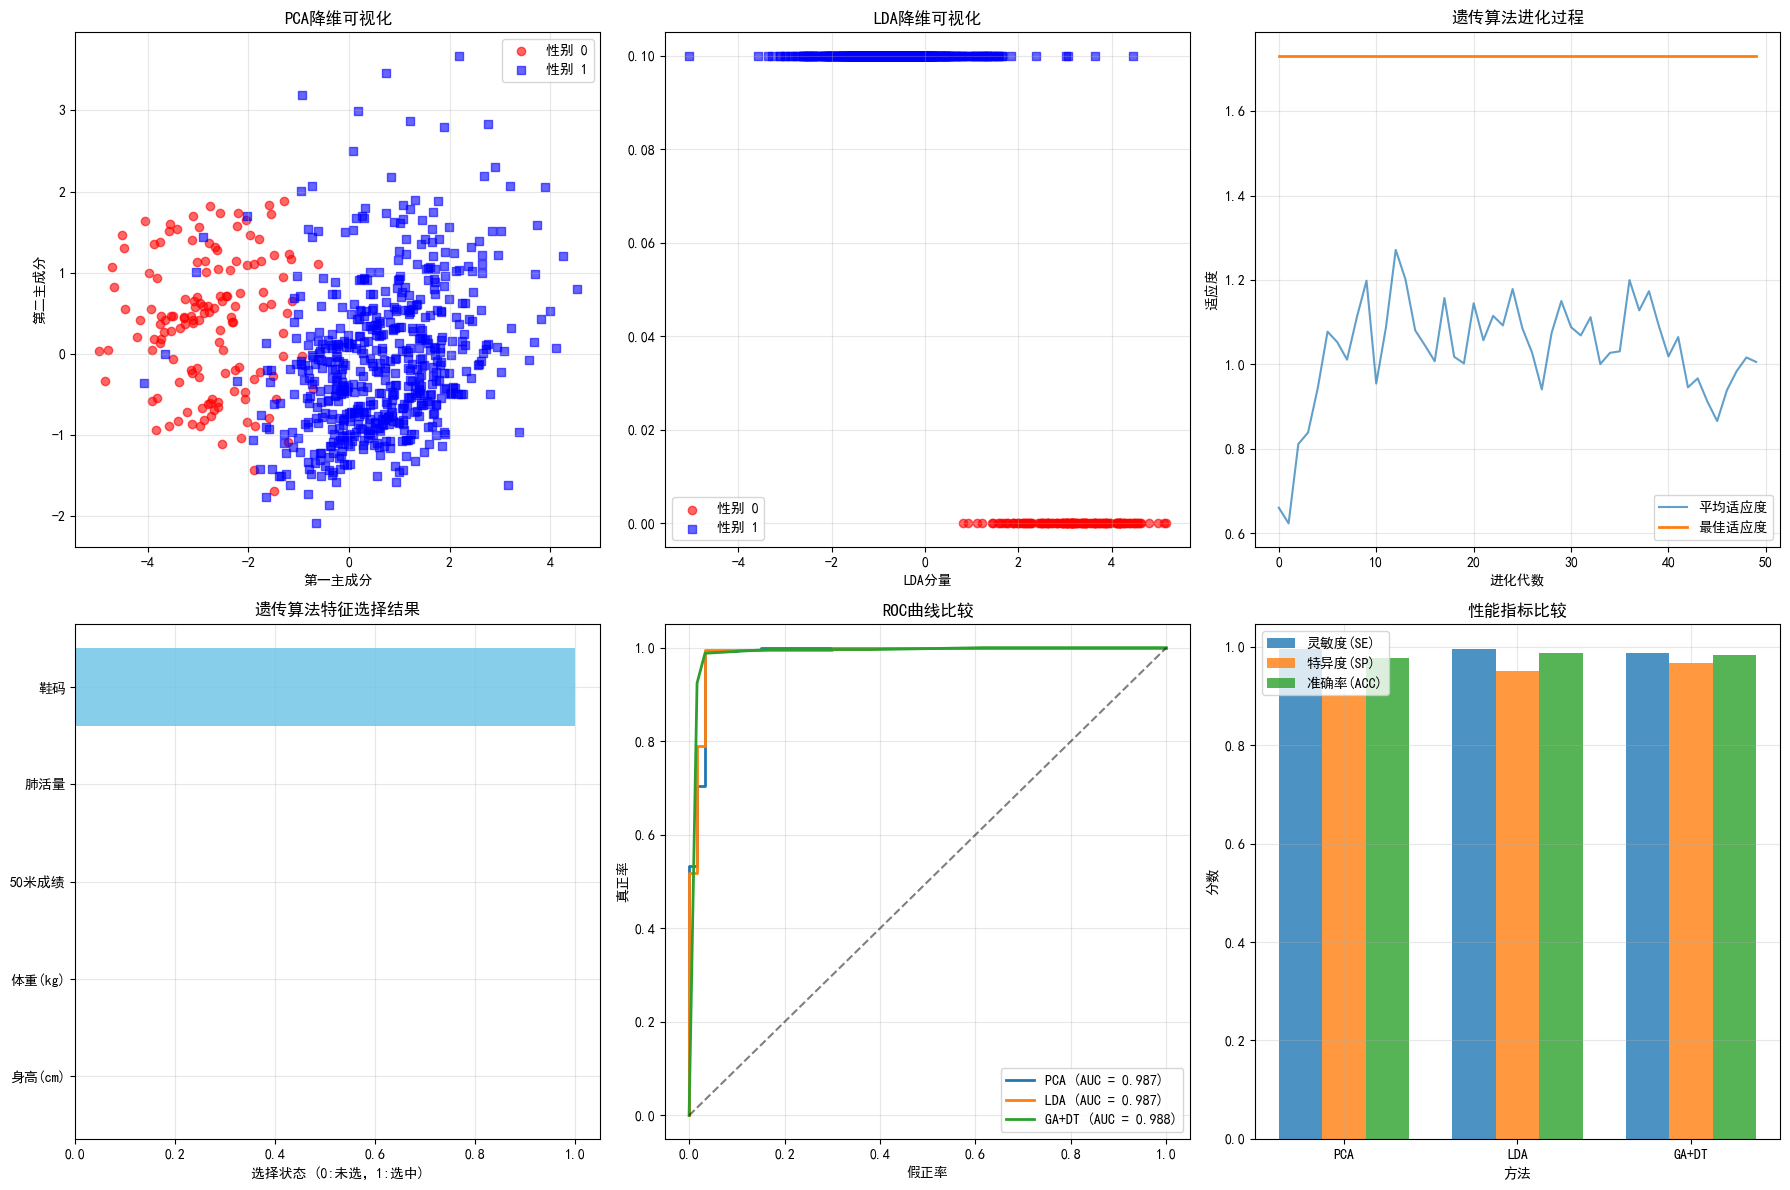


6. 结果分析和详细输出...
PCA降维分析:
- 保留的方差比例: 0.798
- 各主成分方差比例: [0.63195619 0.16624396]
- 第一主成分贡献率: 0.632
- 第二主成分贡献率: 0.166

LDA降维分析:
- 类间方差与类内方差比: 1.000

遗传算法特征选择分析:
- 选中的特征数量: 1
- 选中的特征: ['鞋码']
- 最佳适应度值: 1.7326
- 特征选择比例: 20.0%

性能对比分析:
+----------------------------------------------------------+
|     方法     |    SE    |    SP    |   ACC    |   AUC    |
+----------------------------------------------------------+
|    PCA     |  0.996   |  0.900   |  0.977   |  0.987   |
|    LDA     |  0.996   |  0.950   |  0.987   |  0.987   |
|   GA+DT    |  0.988   |  0.967   |  0.984   |  0.988   |
+----------------------------------------------------------+

方法特点对比:
1. PCA (主成分分析):
   - 无监督降维方法
   - 最大化方差，保持数据全局结构
   - 适用于特征间相关性较高的场景
   - 不利用类别信息

2. LDA (线性判别分析):
   - 有监督降维方法
   - 最大化类间距离，最小化类内距离
   - 直接针对分类任务优化
   - 需要类别标签信息

3. 遗传算法特征选择:
   - 全局优化方法，避免局部最优
   - 可处理特征间的复杂关系
   - 计算成本较高，但能获得更好的特征子集
   - 基于类间类内散度比进行特征评估

详细性能分析:
1. 灵敏度比较:
   - PCA: 0.996 (识别男性的能力)
   - LDA: 0.996 (识别男性的能力)
   - GA+DT: 0

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import random
from tqdm import tqdm

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

print("1. 数据加载和预处理...")

# 读取Excel数据
data = pd.read_excel('2025-模式识别作业数据集汇总-.xlsx', sheet_name='Sheet1')

# 定义特征列 - 根据实际数据集调整
features_pca = ["身高(cm)", "体重(kg)", "50米成绩", "肺活量", "鞋码"]
features_ga = ["身高(cm)", "体重(kg)", "50米成绩", "肺活量", "鞋码"]

# 数据清洗函数
def clean_data(data, features, target_col='性别 男1女0'):
    data_clean = data.copy()
    
    # 处理目标列
    data_clean[target_col] = pd.to_numeric(data_clean[target_col], errors='coerce')
    data_clean = data_clean[data_clean[target_col].isin([0, 1])]
    
    # 处理特征列
    for feature in features:
        data_clean[feature] = pd.to_numeric(data_clean[feature], errors='coerce')
        # 去除异常值（3σ原则）
        mean = data_clean[feature].mean()
        std = data_clean[feature].std()
        data_clean = data_clean[(data_clean[feature] >= mean - 3*std) & 
                               (data_clean[feature] <= mean + 3*std)]
    
    # 删除缺失值
    data_clean = data_clean.dropna(subset=features + [target_col])
    return data_clean

# 分别处理PCA和遗传算法数据
data_pca = clean_data(data, features_pca)
data_ga = clean_data(data, features_ga)

print(f"PCA数据量: {len(data_pca)}")
print(f"遗传算法数据量: {len(data_ga)}")

# 数据基本信息输出
print(f"\n数据基本信息:")
print(f"总样本数: {len(data)}")
print(f"清洗后PCA样本数: {len(data_pca)} ({len(data_pca)/len(data)*100:.1f}%)")
print(f"清洗后遗传算法样本数: {len(data_ga)} ({len(data_ga)/len(data)*100:.1f}%)")
print(f"男女比例 - 男: {sum(data_pca['性别 男1女0']==1)}, 女: {sum(data_pca['性别 男1女0']==0)}")

# 2. PCA降维与分类
print("\n2. PCA降维与分类...")

# PCA数据准备
X_pca = data_pca[features_pca].values
y_pca = data_pca['性别 男1女0'].values

# 数据标准化
scaler_pca = StandardScaler()
X_pca_scaled = scaler_pca.fit_transform(X_pca)

# 划分训练测试集
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca_scaled, y_pca, test_size=0.3, random_state=42, stratify=y_pca)

# PCA降维
pca = PCA(n_components=2)
X_train_pca_reduced = pca.fit_transform(X_train_pca)
X_test_pca_reduced = pca.transform(X_test_pca)

# PCA分类
classifier_pca = LogisticRegression(random_state=42)
classifier_pca.fit(X_train_pca_reduced, y_train_pca)
y_pred_pca = classifier_pca.predict(X_test_pca_reduced)
y_prob_pca = classifier_pca.predict_proba(X_test_pca_reduced)[:, 1]

# 计算性能指标
def calculate_metrics(y_true, y_pred, y_prob):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    SE = tp / (tp + fn)  # 灵敏度
    SP = tn / (tn + fp)  # 特异度
    ACC = accuracy_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    AUC = auc(fpr, tpr)
    return SE, SP, ACC, AUC, fpr, tpr, tn, fp, fn, tp

SE_pca, SP_pca, ACC_pca, AUC_pca, fpr_pca, tpr_pca, tn_pca, fp_pca, fn_pca, tp_pca = calculate_metrics(
    y_test_pca, y_pred_pca, y_prob_pca)

print(f"PCA性能指标:")
print(f"SE (灵敏度): {SE_pca:.4f}")
print(f"SP (特异度): {SP_pca:.4f}")
print(f"ACC (准确率): {ACC_pca:.4f}")
print(f"AUC: {AUC_pca:.4f}")
print(f"混淆矩阵 - TP: {tp_pca}, FP: {fp_pca}, TN: {tn_pca}, FN: {fn_pca}")

# 3. LDA降维与分类
print("\n3. LDA降维与分类...")

# LDA降维
lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train_pca, y_train_pca)
X_test_lda = lda.transform(X_test_pca)

# LDA分类
classifier_lda = LogisticRegression(random_state=42)
classifier_lda.fit(X_train_lda, y_train_pca)
y_pred_lda = classifier_lda.predict(X_test_lda)
y_prob_lda = classifier_lda.predict_proba(X_test_lda)[:, 1]

# 计算LDA性能指标
SE_lda, SP_lda, ACC_lda, AUC_lda, fpr_lda, tpr_lda, tn_lda, fp_lda, fn_lda, tp_lda = calculate_metrics(
    y_test_pca, y_pred_lda, y_prob_lda)

print(f"LDA性能指标:")
print(f"SE (灵敏度): {SE_lda:.4f}")
print(f"SP (特异度): {SP_lda:.4f}")
print(f"ACC (准确率): {ACC_lda:.4f}")
print(f"AUC: {AUC_lda:.4f}")
print(f"混淆矩阵 - TP: {tp_lda}, FP: {fp_lda}, TN: {tn_lda}, FN: {fn_lda}")

# 4. 遗传算法特征选择
print("\n4. 遗传算法特征选择...")

class GeneticAlgorithm:
    def __init__(self, n_features, pop_size=50, n_generations=100, crossover_rate=0.8, mutation_rate=0.1):
        self.n_features = n_features
        self.pop_size = pop_size
        self.n_generations = n_generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate

    def initialize_population(self):
        return np.random.randint(0, 2, (self.pop_size, self.n_features))

    def fitness_function(self, individual, X, y):
        # 如果没有选择任何特征，返回很小的适应度
        if np.sum(individual) == 0:
            return 1e-6
        
        # 选择特征
        selected_features = individual.astype(bool)
        X_selected = X[:, selected_features]
        
        # 检查数据有效性
        n_samples, n_features = X_selected.shape
        classes = np.unique(y)
        n_classes = len(classes)
        
        if n_features == 0:
            return 1e-6
        
        # 计算总体均值
        overall_mean = np.mean(X_selected, axis=0)
        
        # 计算类内散度矩阵
        Sw = np.zeros((n_features, n_features))
        for c in classes:
            X_c = X_selected[y == c]
            mean_c = np.mean(X_c, axis=0)
            Sw += (X_c - mean_c).T @ (X_c - mean_c)
        
        # 计算类间散度矩阵
        Sb = np.zeros((n_features, n_features))
        for c in classes:
            X_c = X_selected[y == c]
            mean_c = np.mean(X_c, axis=0)
            n_c = len(X_c)
            Sb += n_c * (mean_c - overall_mean).reshape(-1, 1) @ (mean_c - overall_mean).reshape(1, -1)
        
        # 添加正则化项避免奇异矩阵
        Sw += np.eye(n_features) * 1e-6
        
        # 计算适应度: J = Tr(Sb) / Tr(Sw)
        try:
            fitness = np.trace(Sb) / np.trace(Sw)
        except:
            fitness = 1e-6
        
        return fitness

    def selection(self, population, fitness_values):
        # 轮盘赌选择
        fitness_values = np.array(fitness_values)
        if np.sum(fitness_values) == 0:
            probabilities = np.ones(len(fitness_values)) / len(fitness_values)
        else:
            probabilities = fitness_values / np.sum(fitness_values)
        
        selected_indices = np.random.choice(
            len(population),
            size=self.pop_size,
            p=probabilities
        )
        return population[selected_indices]

    def crossover(self, parent1, parent2):
        if np.random.rand() < self.crossover_rate:
            point = np.random.randint(1, self.n_features)
            child1 = np.concatenate([parent1[:point], parent2[point:]])
            child2 = np.concatenate([parent2[:point], parent1[point:]])
            return child1, child2
        else:
            return parent1.copy(), parent2.copy()

    def mutation(self, individual):
        for i in range(self.n_features):
            if np.random.rand() < self.mutation_rate:
                individual[i] = 1 - individual[i]
        return individual

    def run(self, X, y):
        population = self.initialize_population()
        best_individual = None
        best_fitness = -np.inf
        fitness_history = []
        best_fitness_history = []
        
        for generation in tqdm(range(self.n_generations)):
            # 计算适应度
            fitness_values = [self.fitness_function(ind, X, y) for ind in population]
            
            # 更新最佳个体
            current_best_fitness = np.max(fitness_values)
            current_best_index = np.argmax(fitness_values)
            
            if current_best_fitness > best_fitness:
                best_fitness = current_best_fitness
                best_individual = population[current_best_index].copy()
            
            fitness_history.append(np.mean(fitness_values))
            best_fitness_history.append(best_fitness)
            
            # 选择
            selected_population = self.selection(population, fitness_values)
            
            # 交叉和变异
            new_population = []
            for i in range(0, self.pop_size, 2):
                parent1 = selected_population[i]
                parent2 = selected_population[(i + 1) % self.pop_size]
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutation(child1)
                child2 = self.mutation(child2)
                new_population.extend([child1, child2])
            
            population = np.array(new_population[:self.pop_size])
        
        return best_individual, best_fitness, fitness_history, best_fitness_history

# 遗传算法数据准备
X_ga = data_ga[features_ga].values
y_ga = data_ga['性别 男1女0'].values

# 数据标准化
scaler_ga = StandardScaler()
X_ga_scaled = scaler_ga.fit_transform(X_ga)

# 划分训练测试集
X_train_ga, X_test_ga, y_train_ga, y_test_ga = train_test_split(
    X_ga_scaled, y_ga, test_size=0.3, random_state=42, stratify=y_ga)

# 运行遗传算法
ga = GeneticAlgorithm(n_features=len(features_ga), pop_size=30, n_generations=50)
best_individual, best_fitness, fitness_history, best_fitness_history = ga.run(X_train_ga, y_train_ga)

print(f"最佳个体: {best_individual}")
print(f"最佳适应度: {best_fitness:.4f}")
selected_features = [features_ga[i] for i in range(len(features_ga)) if best_individual[i] == 1]
print(f"选中的特征: {selected_features}")

# 使用选中的特征进行分类
selected_features_mask = best_individual.astype(bool)
X_train_ga_selected = X_train_ga[:, selected_features_mask]
X_test_ga_selected = X_test_ga[:, selected_features_mask]

# 决策树分类
dt_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_classifier.fit(X_train_ga_selected, y_train_ga)
y_pred_ga = dt_classifier.predict(X_test_ga_selected)
y_prob_ga = dt_classifier.predict_proba(X_test_ga_selected)[:, 1]

# 计算遗传算法性能指标
SE_ga, SP_ga, ACC_ga, AUC_ga, fpr_ga, tpr_ga, tn_ga, fp_ga, fn_ga, tp_ga = calculate_metrics(
    y_test_ga, y_pred_ga, y_prob_ga)

print(f"遗传算法+决策树性能指标:")
print(f"SE (灵敏度): {SE_ga:.4f}")
print(f"SP (特异度): {SP_ga:.4f}")
print(f"ACC (准确率): {ACC_ga:.4f}")
print(f"AUC: {AUC_ga:.4f}")
print(f"混淆矩阵 - TP: {tp_ga}, FP: {fp_ga}, TN: {tn_ga}, FN: {fn_ga}")

# 5. 结果可视化
print("\n5. 结果可视化...")

# 创建子图
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 5.1 PCA和LDA降维可视化
colors = ['red', 'blue']
markers = ['o', 's']

# PCA可视化
for i, label in enumerate([0, 1]):
    mask = y_train_pca == label
    axes[0, 0].scatter(X_train_pca_reduced[mask, 0], X_train_pca_reduced[mask, 1],
                      c=colors[i], marker=markers[i], label=f'性别 {label}', alpha=0.6)
axes[0, 0].set_xlabel('第一主成分')
axes[0, 0].set_ylabel('第二主成分')
axes[0, 0].set_title('PCA降维可视化')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# LDA可视化
for i, label in enumerate([0, 1]):
    mask = y_train_pca == label
    axes[0, 1].scatter(X_train_lda[mask], np.zeros_like(X_train_lda[mask]) + i*0.1,
                      c=colors[i], marker=markers[i], label=f'性别 {label}', alpha=0.6)
axes[0, 1].set_xlabel('LDA分量')
axes[0, 1].set_title('LDA降维可视化')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 5.2 遗传算法进化过程
axes[0, 2].plot(fitness_history, label='平均适应度', alpha=0.7)
axes[0, 2].plot(best_fitness_history, label='最佳适应度', linewidth=2)
axes[0, 2].set_xlabel('进化代数')
axes[0, 2].set_ylabel('适应度')
axes[0, 2].set_title('遗传算法进化过程')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 5.3 特征选择结果
feature_scores = best_individual
axes[1, 0].barh(features_ga, feature_scores, color='skyblue')
axes[1, 0].set_xlabel('选择状态 (0:未选，1:选中)')
axes[1, 0].set_title('遗传算法特征选择结果')
axes[1, 0].grid(True, alpha=0.3)

# 5.4 ROC曲线
axes[1, 1].plot(fpr_pca, tpr_pca, label=f'PCA (AUC = {AUC_pca:.3f})', linewidth=2)
axes[1, 1].plot(fpr_lda, tpr_lda, label=f'LDA (AUC = {AUC_lda:.3f})', linewidth=2)
axes[1, 1].plot(fpr_ga, tpr_ga, label=f'GA+DT (AUC = {AUC_ga:.3f})', linewidth=2)
axes[1, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1, 1].set_xlabel('假正率')
axes[1, 1].set_ylabel('真正率')
axes[1, 1].set_title('ROC曲线比较')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 5.5 性能指标比较
methods = ['PCA', 'LDA', 'GA+DT']
SE_values = [SE_pca, SE_lda, SE_ga]
SP_values = [SP_pca, SP_lda, SP_ga]
ACC_values = [ACC_pca, ACC_lda, ACC_ga]

x = np.arange(len(methods))
width = 0.25

axes[1, 2].bar(x - width, SE_values, width, label='灵敏度(SE)', alpha=0.8)
axes[1, 2].bar(x, SP_values, width, label='特异度(SP)', alpha=0.8)
axes[1, 2].bar(x + width, ACC_values, width, label='准确率(ACC)', alpha=0.8)
axes[1, 2].set_xlabel('方法')
axes[1, 2].set_ylabel('分数')
axes[1, 2].set_title('性能指标比较')
axes[1, 2].set_xticks(x)
axes[1, 2].set_xticklabels(methods)
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6. 结果分析和详细输出
print("\n6. 结果分析和详细输出...")
print("="*60)

print("PCA降维分析:")
print(f"- 保留的方差比例: {np.sum(pca.explained_variance_ratio_):.3f}")
print(f"- 各主成分方差比例: {pca.explained_variance_ratio_}")
print(f"- 第一主成分贡献率: {pca.explained_variance_ratio_[0]:.3f}")
print(f"- 第二主成分贡献率: {pca.explained_variance_ratio_[1]:.3f}")

print("\nLDA降维分析:")
print(f"- 类间方差与类内方差比: {lda.explained_variance_ratio_[0]:.3f}")

print("\n遗传算法特征选择分析:")
print(f"- 选中的特征数量: {np.sum(best_individual)}")
print(f"- 选中的特征: {selected_features}")
print(f"- 最佳适应度值: {best_fitness:.4f}")
print(f"- 特征选择比例: {np.sum(best_individual)/len(features_ga)*100:.1f}%")

print("\n性能对比分析:")
print("+" + "-"*58 + "+")
print("| {:^10} | {:^8} | {:^8} | {:^8} | {:^8} |".format("方法", "SE", "SP", "ACC", "AUC"))
print("+" + "-"*58 + "+")
print("| {:^10} | {:^8.3f} | {:^8.3f} | {:^8.3f} | {:^8.3f} |".format("PCA", SE_pca, SP_pca, ACC_pca, AUC_pca))
print("| {:^10} | {:^8.3f} | {:^8.3f} | {:^8.3f} | {:^8.3f} |".format("LDA", SE_lda, SP_lda, ACC_lda, AUC_lda))
print("| {:^10} | {:^8.3f} | {:^8.3f} | {:^8.3f} | {:^8.3f} |".format("GA+DT", SE_ga, SP_ga, ACC_ga, AUC_ga))
print("+" + "-"*58 + "+")

print("\n方法特点对比:")
print("1. PCA (主成分分析):")
print("   - 无监督降维方法")
print("   - 最大化方差，保持数据全局结构")
print("   - 适用于特征间相关性较高的场景")
print("   - 不利用类别信息")

print("\n2. LDA (线性判别分析):")
print("   - 有监督降维方法")
print("   - 最大化类间距离，最小化类内距离")
print("   - 直接针对分类任务优化")
print("   - 需要类别标签信息")

print("\n3. 遗传算法特征选择:")
print("   - 全局优化方法，避免局部最优")
print("   - 可处理特征间的复杂关系")
print("   - 计算成本较高，但能获得更好的特征子集")
print("   - 基于类间类内散度比进行特征评估")

print("\n详细性能分析:")
print(f"1. 灵敏度比较:")
print(f"   - PCA: {SE_pca:.3f} (识别男性的能力)")
print(f"   - LDA: {SE_lda:.3f} (识别男性的能力)") 
print(f"   - GA+DT: {SE_ga:.3f} (识别男性的能力)")

print(f"\n2. 特异度比较:")
print(f"   - PCA: {SP_pca:.3f} (识别女性的能力)")
print(f"   - LDA: {SP_lda:.3f} (识别女性的能力)")
print(f"   - GA+DT: {SP_ga:.3f} (识别女性的能力)")

print(f"\n3. 综合性能:")
print(f"   - 准确率最高: {'LDA' if ACC_lda > max(ACC_pca, ACC_ga) else 'PCA' if ACC_pca > ACC_ga else 'GA+DT'}")
print(f"   - AUC最高: {'LDA' if AUC_lda > max(AUC_pca, AUC_ga) else 'PCA' if AUC_pca > AUC_ga else 'GA+DT'}")
print(f"   - 平衡性最好: {'LDA' if min(SE_lda, SP_lda) > min(SE_pca, SP_pca) and min(SE_lda, SP_lda) > min(SE_ga, SP_ga) else 'PCA' if min(SE_pca, SP_pca) > min(SE_ga, SP_ga) else 'GA+DT'}")

print("\n结论:")
if ACC_ga > max(ACC_pca, ACC_lda):
    print("遗传算法特征选择结合决策树在本数据集上表现最佳，能够用更少的特征达到较好的分类效果")
elif ACC_lda > ACC_pca:
    print("LDA作为有监督降维方法在分类任务上表现更好，充分利用了类别信息")
else:
    print("PCA作为无监督降维方法在保持数据全局结构方面表现稳定")

print(f"\n推荐方案:")
best_method = 'LDA' if ACC_lda > max(ACC_pca, ACC_ga) else 'PCA' if ACC_pca > ACC_ga else 'GA+DT'
print(f"   - 对于此性别分类任务，推荐使用 {best_method} 方法")
if best_method == 'GA+DT':
    print(f"   - 遗传算法选择了 {selected_features} 作为关键特征")
    print(f"   - 仅使用 {len(selected_features)} 个特征就达到了较好的分类效果")

print("\n模型应用建议:")
print("1. 如果计算资源充足且追求最佳性能: 使用LDA方法")
print("2. 如果需要特征解释性: 使用遗传算法特征选择")
print("3. 如果数据标签不可用: 使用PCA方法")
print("4. 实际部署考虑: 根据准确率、计算成本和可解释性进行权衡")

1. 数据加载和预处理...
数据基本信息:
数据形状: (1075, 11)
列名: ['编号', '性别 男1女0', '籍贯', '身高(cm)', '体重(kg)', '鞋码', '50米成绩', '肺活量', '喜欢颜色', '喜欢运动', '喜欢文学']

前5行数据:
   编号 性别 男1女0  籍贯  身高(cm)  体重(kg)    鞋码 50米成绩   肺活量 喜欢颜色  喜欢运动  喜欢文学
0   1       1  湖北   163.0    51.0  41.0   7.5  2500    蓝   1.0   1.0
1   2       1  河南   171.0    64.0  41.0   7.5  3500    蓝   0.0   0.0
2   3       1  云南   182.0    68.0  45.0   7.8  4900    蓝   1.0   0.0
3   4       1  广西   172.0    66.0  42.0   8.2  4800    绿   0.0   1.0
4   5       1  四川   185.0    80.0  44.0   8.5  5100    蓝   0.0   0.0
PCA数据量: 1035
遗传算法数据量: 1035

数据基本信息:
总样本数: 1075
清洗后PCA样本数: 1035 (96.3%)
清洗后遗传算法样本数: 1035 (96.3%)
男女比例 - 男: 835, 女: 200

1.1 数据探索性分析...


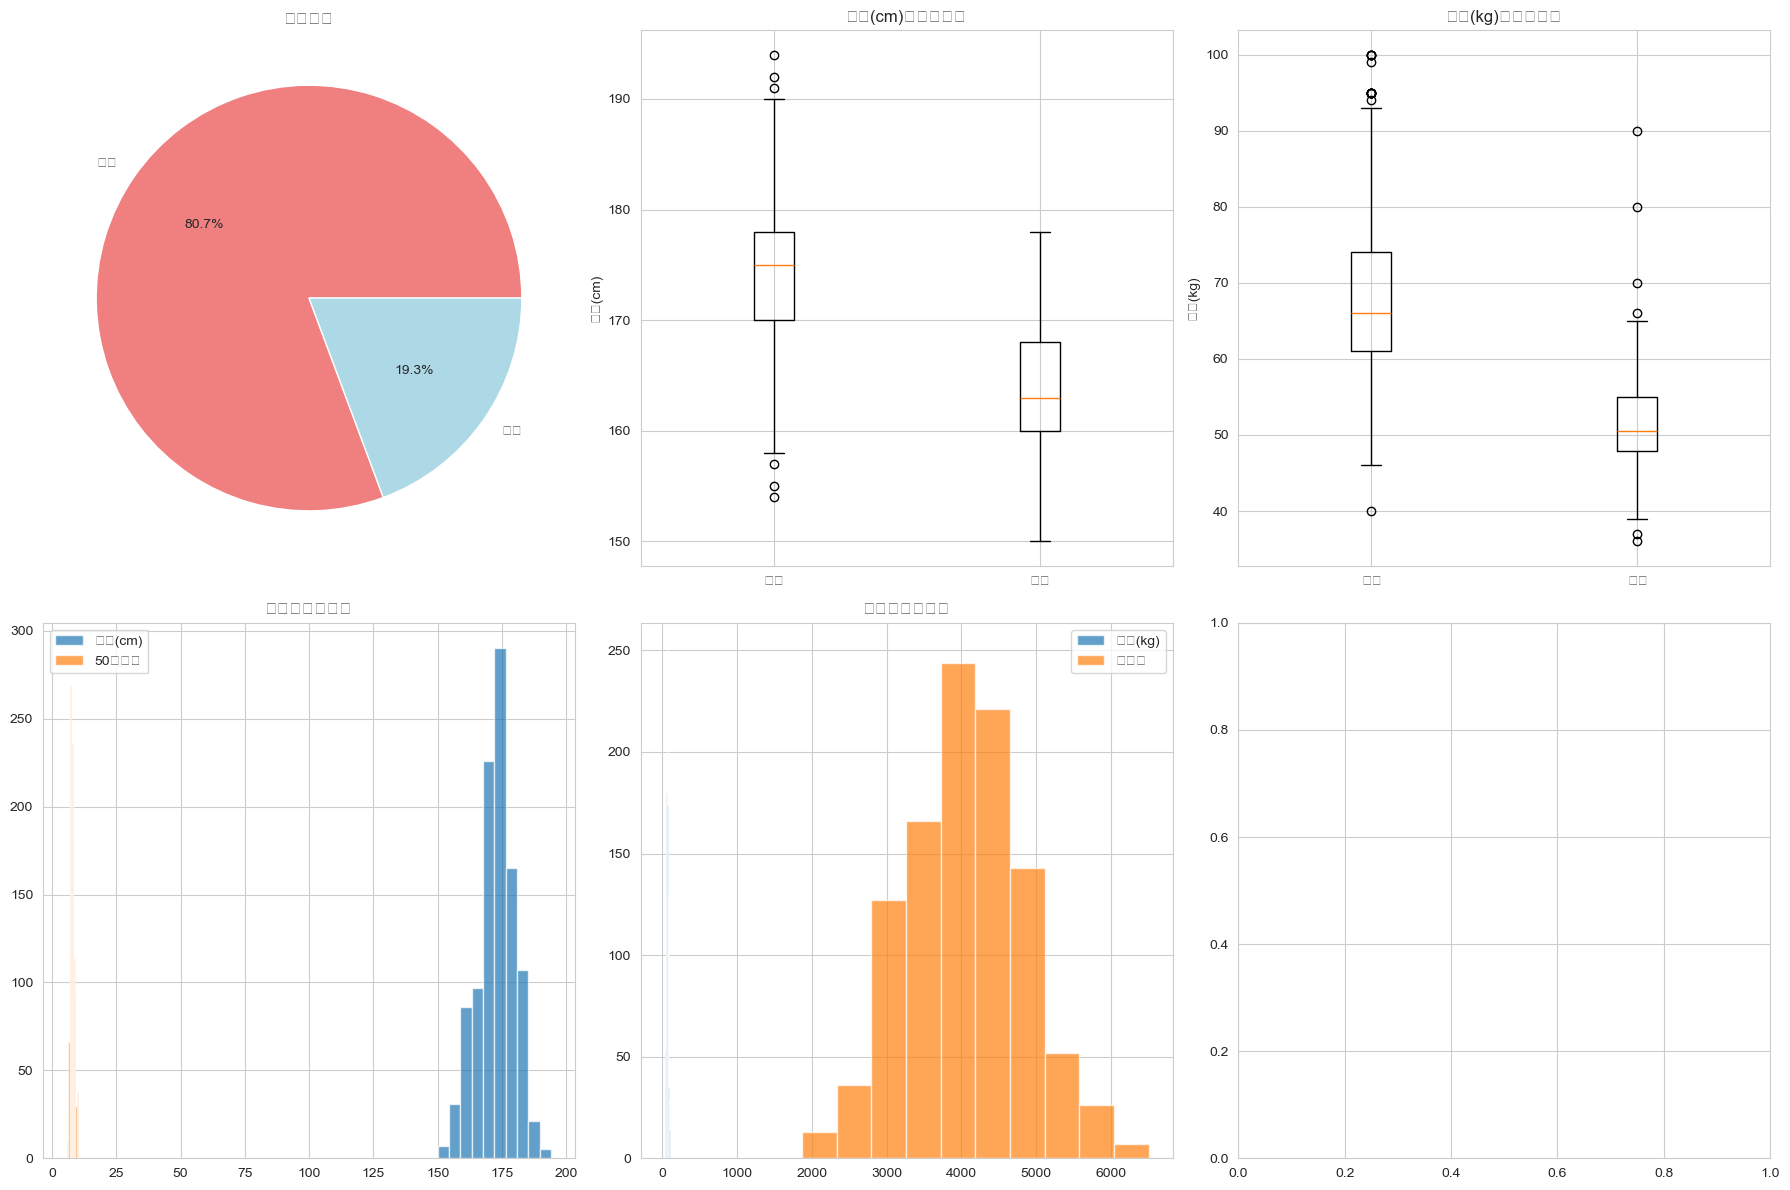

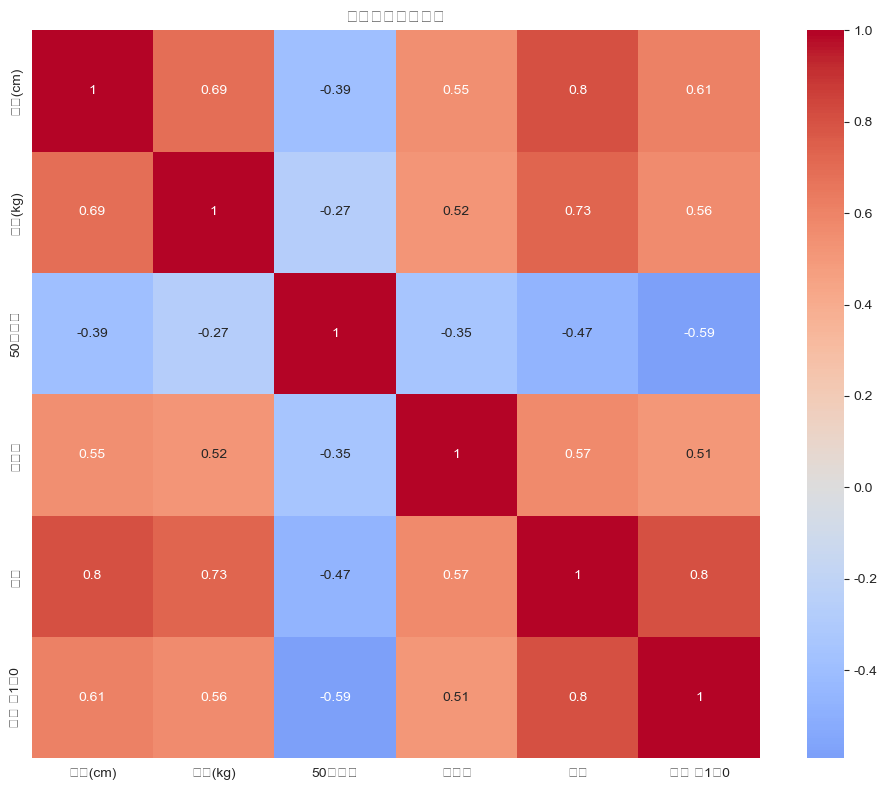

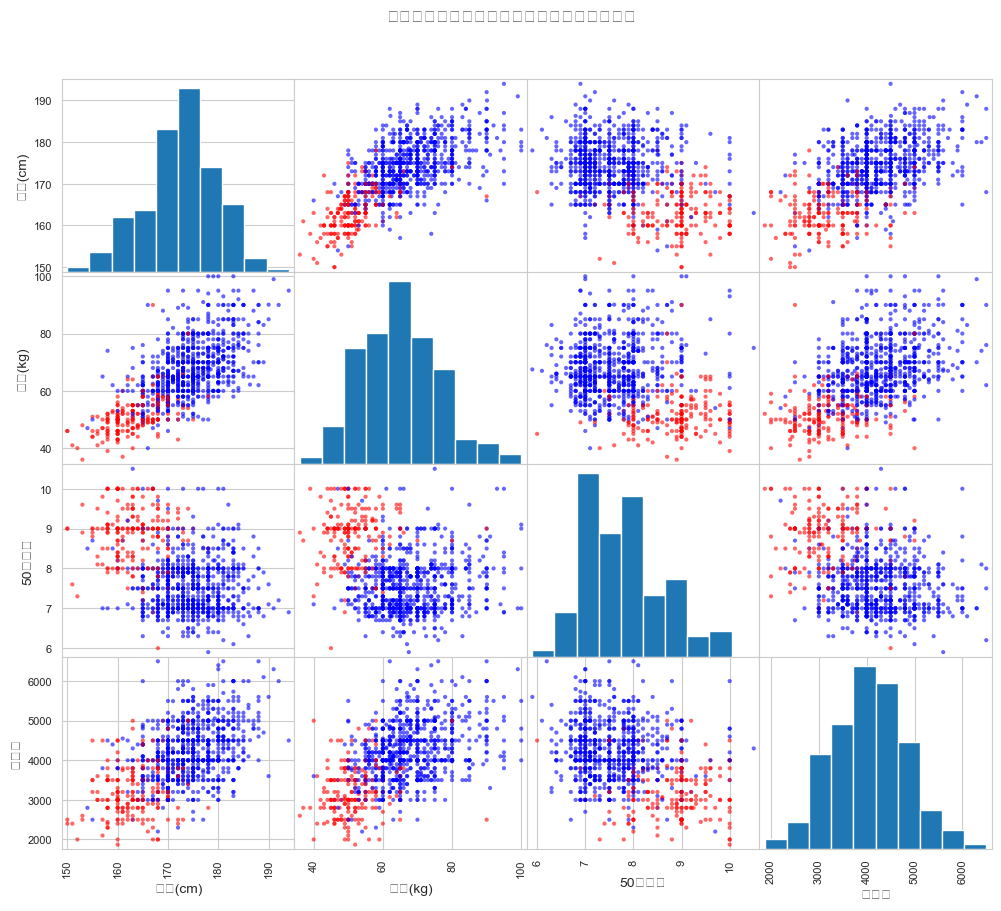


2. PCA降维与分类...


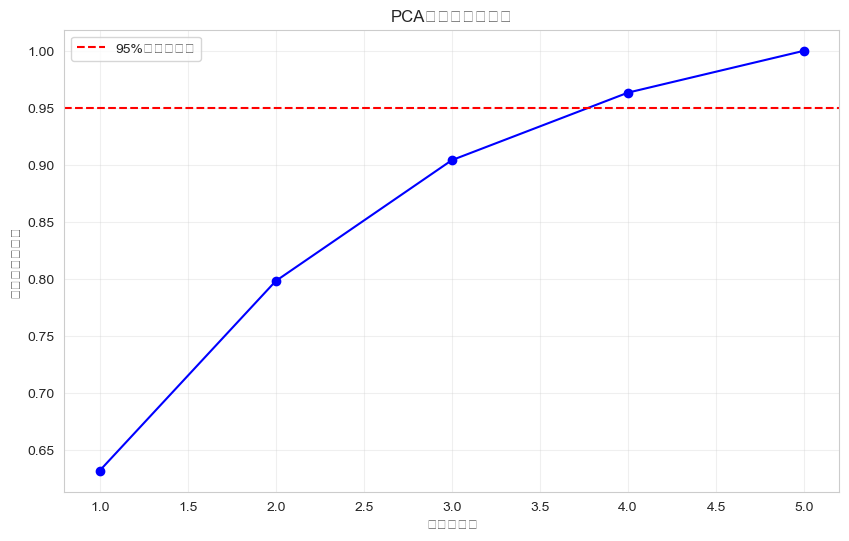

PCA性能指标:
SE (灵敏度): 0.9960
SP (特异度): 0.9000
ACC (准确率): 0.9775
AUC: 0.9866
精确率: 0.9766
F1分数: 0.9862
混淆矩阵 - TP: 250, FP: 6, TN: 54, FN: 1

3. LDA降维与分类...
LDA性能指标:
SE (灵敏度): 0.9960
SP (特异度): 0.9500
ACC (准确率): 0.9871
AUC: 0.9874
精确率: 0.9881
F1分数: 0.9921
混淆矩阵 - TP: 250, FP: 3, TN: 57, FN: 1

4. 多种分类器比较...
逻辑回归: ACC=0.9871, AUC=0.9881, F1=0.9921
决策树: ACC=0.9743, AUC=0.9524, F1=0.9841
随机森林: ACC=0.9839, AUC=0.9955, F1=0.9901
K近邻: ACC=0.9807, AUC=0.9781, F1=0.9880
支持向量机: ACC=0.9871, AUC=0.9928, F1=0.9920
朴素贝叶斯: ACC=0.9839, AUC=0.9875, F1=0.9900


KeyError: 'F1'

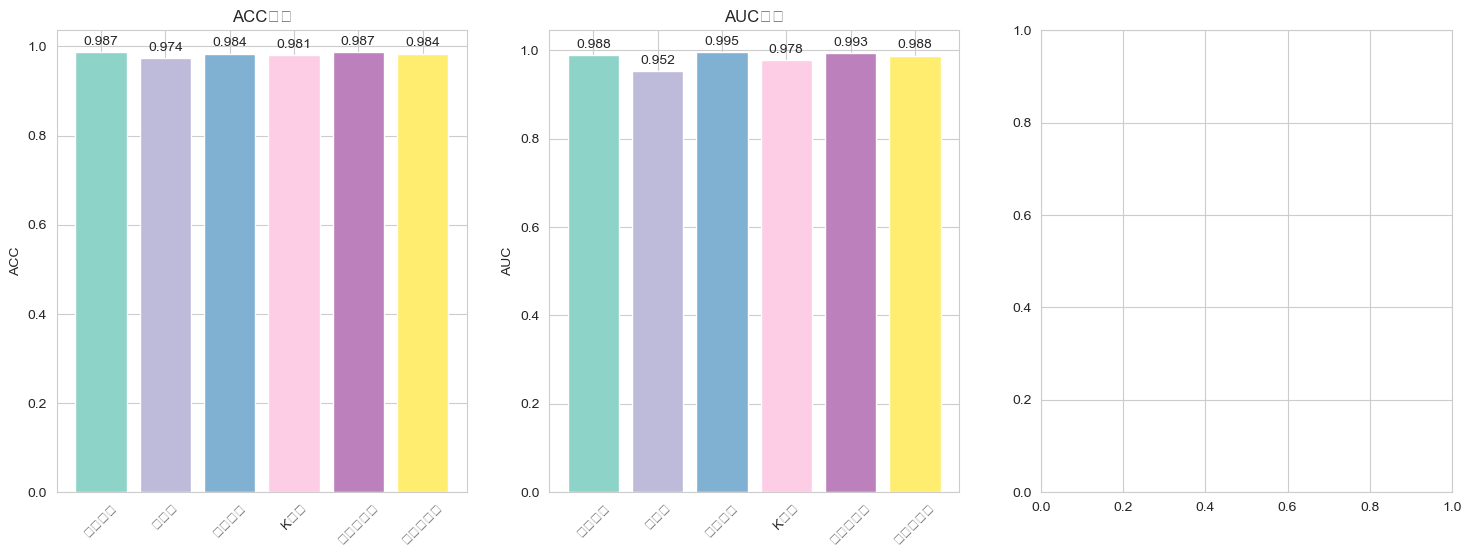

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
import scipy.stats as stats
#from scipy import interp
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体和图形样式
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("1. 数据加载和预处理...")

# 读取Excel数据
data = pd.read_excel('2025-模式识别作业数据集汇总-.xlsx', sheet_name='Sheet1')

# 显示数据基本信息
print("数据基本信息:")
print(f"数据形状: {data.shape}")
print(f"列名: {list(data.columns)}")
print("\n前5行数据:")
print(data.head())

# 定义特征列 - 根据实际数据集调整
features_pca = ["身高(cm)", "体重(kg)", "50米成绩", "肺活量", "鞋码"]
features_ga = ["身高(cm)", "体重(kg)", "50米成绩", "肺活量", "鞋码"]

# 数据清洗函数
def clean_data(data, features, target_col='性别 男1女0'):
    data_clean = data.copy()
    
    # 处理目标列
    data_clean[target_col] = pd.to_numeric(data_clean[target_col], errors='coerce')
    data_clean = data_clean[data_clean[target_col].isin([0, 1])]
    
    # 处理特征列
    for feature in features:
        data_clean[feature] = pd.to_numeric(data_clean[feature], errors='coerce')
        # 去除异常值（3σ原则）
        mean = data_clean[feature].mean()
        std = data_clean[feature].std()
        data_clean = data_clean[(data_clean[feature] >= mean - 3*std) & 
                               (data_clean[feature] <= mean + 3*std)]
    
    # 删除缺失值
    data_clean = data_clean.dropna(subset=features + [target_col])
    return data_clean

# 分别处理PCA和遗传算法数据
data_pca = clean_data(data, features_pca)
data_ga = clean_data(data, features_ga)

print(f"PCA数据量: {len(data_pca)}")
print(f"遗传算法数据量: {len(data_ga)}")

# 数据基本信息输出
print(f"\n数据基本信息:")
print(f"总样本数: {len(data)}")
print(f"清洗后PCA样本数: {len(data_pca)} ({len(data_pca)/len(data)*100:.1f}%)")
print(f"清洗后遗传算法样本数: {len(data_ga)} ({len(data_ga)/len(data)*100:.1f}%)")
print(f"男女比例 - 男: {sum(data_pca['性别 男1女0']==1)}, 女: {sum(data_pca['性别 男1女0']==0)}")

# 1.1 数据探索性分析
print("\n1.1 数据探索性分析...")

# 创建数据探索性分析图表
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1.1.1 性别分布
gender_counts = data_pca['性别 男1女0'].value_counts()
axes[0, 0].pie(gender_counts.values, labels=['女性', '男性'], autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
axes[0, 0].set_title('性别分布')

# 1.1.2 特征分布直方图
for i, feature in enumerate(features_pca[:4]):
    row, col = i//2, i%2
    data_pca[feature].hist(ax=axes[1, col], alpha=0.7, label=feature)
axes[1, 0].legend()
axes[1, 1].legend()
axes[1, 0].set_title('特征分布直方图')
axes[1, 1].set_title('特征分布直方图')

# 1.1.3 性别与特征的关系
for i, feature in enumerate(features_pca[:2]):
    male_data = data_pca[data_pca['性别 男1女0'] == 1][feature]
    female_data = data_pca[data_pca['性别 男1女0'] == 0][feature]
    
    axes[0, 1+i].boxplot([male_data, female_data], labels=['男性', '女性'])
    axes[0, 1+i].set_title(f'{feature}的性别差异')
    axes[0, 1+i].set_ylabel(feature)

plt.tight_layout()
plt.show()

# 1.1.4 特征相关性热力图
plt.figure(figsize=(10, 8))
correlation_matrix = data_pca[features_pca + ['性别 男1女0']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('特征相关性热力图')
plt.tight_layout()
plt.show()

# 1.1.5 特征散点图矩阵
gender_colors = data_pca['性别 男1女0'].map({0: 'red', 1: 'blue'})
pd.plotting.scatter_matrix(data_pca[features_pca[:4]], c=gender_colors, alpha=0.6, figsize=(12, 10))
plt.suptitle('特征散点图矩阵（红色：女性，蓝色：男性）', y=0.95)
plt.show()

# 2. PCA降维与分类
print("\n2. PCA降维与分类...")

# PCA数据准备
X_pca = data_pca[features_pca].values
y_pca = data_pca['性别 男1女0'].values

# 数据标准化
scaler_pca = StandardScaler()
X_pca_scaled = scaler_pca.fit_transform(X_pca)

# 划分训练测试集
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca_scaled, y_pca, test_size=0.3, random_state=42, stratify=y_pca)

# 2.1 PCA方差解释率分析
pca_full = PCA()
pca_full.fit(X_train_pca)

# 绘制方差解释率曲线
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca_full.explained_variance_ratio_)+1), 
         np.cumsum(pca_full.explained_variance_ratio_), 'bo-')
plt.axhline(y=0.95, color='r', linestyle='--', label='95%方差解释率')
plt.xlabel('主成分数量')
plt.ylabel('累积方差解释率')
plt.title('PCA方差解释率曲线')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# PCA降维（选择2个主成分用于可视化）
pca = PCA(n_components=2)
X_train_pca_reduced = pca.fit_transform(X_train_pca)
X_test_pca_reduced = pca.transform(X_test_pca)

# PCA分类
classifier_pca = LogisticRegression(random_state=42)
classifier_pca.fit(X_train_pca_reduced, y_train_pca)
y_pred_pca = classifier_pca.predict(X_test_pca_reduced)
y_prob_pca = classifier_pca.predict_proba(X_test_pca_reduced)[:, 1]

# 计算性能指标
def calculate_metrics(y_true, y_pred, y_prob):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    SE = tp / (tp + fn)  # 灵敏度
    SP = tn / (tn + fp)  # 特异度
    ACC = accuracy_score(y_true, y_pred)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * (precision * SE) / (precision + SE) if (precision + SE) > 0 else 0
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    AUC = auc(fpr, tpr)
    return SE, SP, ACC, AUC, fpr, tpr, tn, fp, fn, tp, precision, f1

SE_pca, SP_pca, ACC_pca, AUC_pca, fpr_pca, tpr_pca, tn_pca, fp_pca, fn_pca, tp_pca, precision_pca, f1_pca = calculate_metrics(
    y_test_pca, y_pred_pca, y_prob_pca)

print(f"PCA性能指标:")
print(f"SE (灵敏度): {SE_pca:.4f}")
print(f"SP (特异度): {SP_pca:.4f}")
print(f"ACC (准确率): {ACC_pca:.4f}")
print(f"AUC: {AUC_pca:.4f}")
print(f"精确率: {precision_pca:.4f}")
print(f"F1分数: {f1_pca:.4f}")
print(f"混淆矩阵 - TP: {tp_pca}, FP: {fp_pca}, TN: {tn_pca}, FN: {fn_pca}")

# 3. LDA降维与分类
print("\n3. LDA降维与分类...")

# LDA降维
lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train_pca, y_train_pca)
X_test_lda = lda.transform(X_test_pca)

# LDA分类
classifier_lda = LogisticRegression(random_state=42)
classifier_lda.fit(X_train_lda, y_train_pca)
y_pred_lda = classifier_lda.predict(X_test_lda)
y_prob_lda = classifier_lda.predict_proba(X_test_lda)[:, 1]

# 计算LDA性能指标
SE_lda, SP_lda, ACC_lda, AUC_lda, fpr_lda, tpr_lda, tn_lda, fp_lda, fn_lda, tp_lda, precision_lda, f1_lda = calculate_metrics(
    y_test_pca, y_pred_lda, y_prob_lda)

print(f"LDA性能指标:")
print(f"SE (灵敏度): {SE_lda:.4f}")
print(f"SP (特异度): {SP_lda:.4f}")
print(f"ACC (准确率): {ACC_lda:.4f}")
print(f"AUC: {AUC_lda:.4f}")
print(f"精确率: {precision_lda:.4f}")
print(f"F1分数: {f1_lda:.4f}")
print(f"混淆矩阵 - TP: {tp_lda}, FP: {fp_lda}, TN: {tn_lda}, FN: {fn_lda}")

# 4. 多种分类器比较
print("\n4. 多种分类器比较...")

classifiers = {
    "逻辑回归": LogisticRegression(random_state=42),
    "决策树": DecisionTreeClassifier(random_state=42),
    "随机森林": RandomForestClassifier(random_state=42),
    "K近邻": KNeighborsClassifier(),
    "支持向量机": SVC(probability=True, random_state=42),
    "朴素贝叶斯": GaussianNB()
}

results = {}

for name, clf in classifiers.items():
    # 使用原始特征训练
    clf.fit(X_train_pca, y_train_pca)
    y_pred = clf.predict(X_test_pca)
    y_prob = clf.predict_proba(X_test_pca)[:, 1]
    
    # 计算性能指标
    SE, SP, ACC, AUC, fpr, tpr, tn, fp, fn, tp, precision, f1 = calculate_metrics(
        y_test_pca, y_pred, y_prob)
    
    results[name] = {
        'SE': SE, 'SP': SP, 'ACC': ACC, 'AUC': AUC, 
        'precision': precision, 'f1': f1
    }
    
    print(f"{name}: ACC={ACC:.4f}, AUC={AUC:.4f}, F1={f1:.4f}")

# 绘制分类器比较图
metrics = ['ACC', 'AUC', 'F1']
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, metric in enumerate(metrics):
    values = [results[name][metric] for name in classifiers.keys()]
    axes[i].bar(classifiers.keys(), values, color=plt.cm.Set3(np.linspace(0, 1, len(classifiers))))
    axes[i].set_title(f'{metric}比较')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)
    
    # 在柱子上添加数值
    for j, v in enumerate(values):
        axes[i].text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 5. 遗传算法特征选择
print("\n5. 遗传算法特征选择...")

class GeneticAlgorithm:
    def __init__(self, n_features, pop_size=50, n_generations=100, crossover_rate=0.8, mutation_rate=0.1):
        self.n_features = n_features
        self.pop_size = pop_size
        self.n_generations = n_generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.feature_selection_history = []

    def initialize_population(self):
        return np.random.randint(0, 2, (self.pop_size, self.n_features))

    def fitness_function(self, individual, X, y):
        # 如果没有选择任何特征，返回很小的适应度
        if np.sum(individual) == 0:
            return 1e-6
        
        # 选择特征
        selected_features = individual.astype(bool)
        X_selected = X[:, selected_features]
        
        # 检查数据有效性
        n_samples, n_features = X_selected.shape
        classes = np.unique(y)
        n_classes = len(classes)
        
        if n_features == 0:
            return 1e-6
        
        # 计算总体均值
        overall_mean = np.mean(X_selected, axis=0)
        
        # 计算类内散度矩阵
        Sw = np.zeros((n_features, n_features))
        for c in classes:
            X_c = X_selected[y == c]
            mean_c = np.mean(X_c, axis=0)
            Sw += (X_c - mean_c).T @ (X_c - mean_c)
        
        # 计算类间散度矩阵
        Sb = np.zeros((n_features, n_features))
        for c in classes:
            X_c = X_selected[y == c]
            mean_c = np.mean(X_c, axis=0)
            n_c = len(X_c)
            Sb += n_c * (mean_c - overall_mean).reshape(-1, 1) @ (mean_c - overall_mean).reshape(1, -1)
        
        # 添加正则化项避免奇异矩阵
        Sw += np.eye(n_features) * 1e-6
        
        # 计算适应度: J = Tr(Sb) / Tr(Sw)
        try:
            fitness = np.trace(Sb) / np.trace(Sw)
        except:
            fitness = 1e-6
        
        return fitness

    def selection(self, population, fitness_values):
        # 轮盘赌选择
        fitness_values = np.array(fitness_values)
        if np.sum(fitness_values) == 0:
            probabilities = np.ones(len(fitness_values)) / len(fitness_values)
        else:
            probabilities = fitness_values / np.sum(fitness_values)
        
        selected_indices = np.random.choice(
            len(population),
            size=self.pop_size,
            p=probabilities
        )
        return population[selected_indices]

    def crossover(self, parent1, parent2):
        if np.random.rand() < self.crossover_rate:
            point = np.random.randint(1, self.n_features)
            child1 = np.concatenate([parent1[:point], parent2[point:]])
            child2 = np.concatenate([parent2[:point], parent1[point:]])
            return child1, child2
        else:
            return parent1.copy(), parent2.copy()

    def mutation(self, individual):
        for i in range(self.n_features):
            if np.random.rand() < self.mutation_rate:
                individual[i] = 1 - individual[i]
        return individual

    def run(self, X, y):
        population = self.initialize_population()
        best_individual = None
        best_fitness = -np.inf
        fitness_history = []
        best_fitness_history = []
        
        for generation in tqdm(range(self.n_generations)):
            # 计算适应度
            fitness_values = [self.fitness_function(ind, X, y) for ind in population]
            
            # 更新最佳个体
            current_best_fitness = np.max(fitness_values)
            current_best_index = np.argmax(fitness_values)
            
            if current_best_fitness > best_fitness:
                best_fitness = current_best_fitness
                best_individual = population[current_best_index].copy()
            
            fitness_history.append(np.mean(fitness_values))
            best_fitness_history.append(best_fitness)
            
            # 记录特征选择历史
            feature_selection_freq = np.mean(population, axis=0)
            self.feature_selection_history.append(feature_selection_freq)
            
            # 选择
            selected_population = self.selection(population, fitness_values)
            
            # 交叉和变异
            new_population = []
            for i in range(0, self.pop_size, 2):
                parent1 = selected_population[i]
                parent2 = selected_population[(i + 1) % self.pop_size]
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutation(child1)
                child2 = self.mutation(child2)
                new_population.extend([child1, child2])
            
            population = np.array(new_population[:self.pop_size])
        
        return best_individual, best_fitness, fitness_history, best_fitness_history

# 遗传算法数据准备
X_ga = data_ga[features_ga].values
y_ga = data_ga['性别 男1女0'].values

# 数据标准化
scaler_ga = StandardScaler()
X_ga_scaled = scaler_ga.fit_transform(X_ga)

# 划分训练测试集
X_train_ga, X_test_ga, y_train_ga, y_test_ga = train_test_split(
    X_ga_scaled, y_ga, test_size=0.3, random_state=42, stratify=y_ga)

# 运行遗传算法
ga = GeneticAlgorithm(n_features=len(features_ga), pop_size=30, n_generations=50)
best_individual, best_fitness, fitness_history, best_fitness_history = ga.run(X_train_ga, y_train_ga)

print(f"最佳个体: {best_individual}")
print(f"最佳适应度: {best_fitness:.4f}")
selected_features = [features_ga[i] for i in range(len(features_ga)) if best_individual[i] == 1]
print(f"选中的特征: {selected_features}")

# 使用选中的特征进行分类
selected_features_mask = best_individual.astype(bool)
X_train_ga_selected = X_train_ga[:, selected_features_mask]
X_test_ga_selected = X_test_ga[:, selected_features_mask]

# 决策树分类
dt_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_classifier.fit(X_train_ga_selected, y_train_ga)
y_pred_ga = dt_classifier.predict(X_test_ga_selected)
y_prob_ga = dt_classifier.predict_proba(X_test_ga_selected)[:, 1]

# 计算遗传算法性能指标
SE_ga, SP_ga, ACC_ga, AUC_ga, fpr_ga, tpr_ga, tn_ga, fp_ga, fn_ga, tp_ga, precision_ga, f1_ga = calculate_metrics(
    y_test_ga, y_pred_ga, y_prob_ga)

print(f"遗传算法+决策树性能指标:")
print(f"SE (灵敏度): {SE_ga:.4f}")
print(f"SP (特异度): {SP_ga:.4f}")
print(f"ACC (准确率): {ACC_ga:.4f}")
print(f"AUC: {AUC_ga:.4f}")
print(f"精确率: {precision_ga:.4f}")
print(f"F1分数: {f1_ga:.4f}")
print(f"混淆矩阵 - TP: {tp_ga}, FP: {fp_ga}, TN: {tn_ga}, FN: {fn_ga}")

# 6. 结果可视化
print("\n6. 结果可视化...")

# 创建子图
fig, axes = plt.subplots(3, 3, figsize=(20, 18))

# 6.1 PCA和LDA降维可视化
colors = ['red', 'blue']
markers = ['o', 's']

# PCA可视化
for i, label in enumerate([0, 1]):
    mask = y_train_pca == label
    axes[0, 0].scatter(X_train_pca_reduced[mask, 0], X_train_pca_reduced[mask, 1],
                      c=colors[i], marker=markers[i], label=f'性别 {label}', alpha=0.6)
axes[0, 0].set_xlabel('第一主成分')
axes[0, 0].set_ylabel('第二主成分')
axes[0, 0].set_title('PCA降维可视化')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# LDA可视化
for i, label in enumerate([0, 1]):
    mask = y_train_pca == label
    axes[0, 1].scatter(X_train_lda[mask], np.zeros_like(X_train_lda[mask]) + i*0.1,
                      c=colors[i], marker=markers[i], label=f'性别 {label}', alpha=0.6)
axes[0, 1].set_xlabel('LDA分量')
axes[0, 1].set_title('LDA降维可视化')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 6.2 遗传算法进化过程
axes[0, 2].plot(fitness_history, label='平均适应度', alpha=0.7)
axes[0, 2].plot(best_fitness_history, label='最佳适应度', linewidth=2)
axes[0, 2].set_xlabel('进化代数')
axes[0, 2].set_ylabel('适应度')
axes[0, 2].set_title('遗传算法进化过程')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 6.3 特征选择结果
feature_scores = best_individual
axes[1, 0].barh(features_ga, feature_scores, color='skyblue')
axes[1, 0].set_xlabel('选择状态 (0:未选，1:选中)')
axes[1, 0].set_title('遗传算法特征选择结果')
axes[1, 0].grid(True, alpha=0.3)

# 6.4 特征选择历史
feature_selection_history = np.array(ga.feature_selection_history)
for i in range(len(features_ga)):
    axes[1, 1].plot(feature_selection_history[:, i], label=features_ga[i], alpha=0.7)
axes[1, 1].set_xlabel('进化代数')
axes[1, 1].set_ylabel('选择频率')
axes[1, 1].set_title('特征选择历史')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6.5 ROC曲线
axes[1, 2].plot(fpr_pca, tpr_pca, label=f'PCA (AUC = {AUC_pca:.3f})', linewidth=2)
axes[1, 2].plot(fpr_lda, tpr_lda, label=f'LDA (AUC = {AUC_lda:.3f})', linewidth=2)
axes[1, 2].plot(fpr_ga, tpr_ga, label=f'GA+DT (AUC = {AUC_ga:.3f})', linewidth=2)
axes[1, 2].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1, 2].set_xlabel('假正率')
axes[1, 2].set_ylabel('真正率')
axes[1, 2].set_title('ROC曲线比较')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

# 6.6 性能指标比较
methods = ['PCA', 'LDA', 'GA+DT']
SE_values = [SE_pca, SE_lda, SE_ga]
SP_values = [SP_pca, SP_lda, SP_ga]
ACC_values = [ACC_pca, ACC_lda, ACC_ga]
AUC_values = [AUC_pca, AUC_lda, AUC_ga]

x = np.arange(len(methods))
width = 0.2

axes[2, 0].bar(x - width*1.5, SE_values, width, label='灵敏度(SE)', alpha=0.8)
axes[2, 0].bar(x - width*0.5, SP_values, width, label='特异度(SP)', alpha=0.8)
axes[2, 0].bar(x + width*0.5, ACC_values, width, label='准确率(ACC)', alpha=0.8)
axes[2, 0].bar(x + width*1.5, AUC_values, width, label='AUC', alpha=0.8)
axes[2, 0].set_xlabel('方法')
axes[2, 0].set_ylabel('分数')
axes[2, 0].set_title('性能指标比较')
axes[2, 0].set_xticks(x)
axes[2, 0].set_xticklabels(methods)
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# 6.7 混淆矩阵热力图
conf_matrices = [
    confusion_matrix(y_test_pca, y_pred_pca),
    confusion_matrix(y_test_pca, y_pred_lda),
    confusion_matrix(y_test_ga, y_pred_ga)
]

titles = ['PCA混淆矩阵', 'LDA混淆矩阵', 'GA+DT混淆矩阵']
for i, (cm, title) in enumerate(zip(conf_matrices, titles)):
    row, col = 2, i
    im = axes[2, 1+i].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axes[2, 1+i].set_title(title)
    
    # 添加数值标签
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[2, 1+i].text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    axes[2, 1+i].set_ylabel('真实标签')
    axes[2, 1+i].set_xlabel('预测标签')
    axes[2, 1+i].set_xticks([0, 1])
    axes[2, 1+i].set_yticks([0, 1])
    axes[2, 1+i].set_xticklabels(['女性', '男性'])
    axes[2, 1+i].set_yticklabels(['女性', '男性'])

plt.tight_layout()
plt.show()

# 7. 高级分析和可视化
print("\n7. 高级分析和可视化...")

# 7.1 学习曲线分析
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

methods_names = ['PCA+逻辑回归', 'LDA+逻辑回归', 'GA+决策树']
classifiers = [classifier_pca, classifier_lda, dt_classifier]
X_trains = [X_train_pca_reduced, X_train_lda, X_train_ga_selected]
X_tests = [X_test_pca_reduced, X_test_lda, X_test_ga_selected]
y_trains = [y_train_pca, y_train_pca, y_train_ga]
y_tests = [y_test_pca, y_test_pca, y_test_ga]

for i, (name, clf, X_train, X_test, y_train, y_test) in enumerate(zip(
    methods_names, classifiers, X_trains, X_tests, y_trains, y_tests)):
    
    train_sizes, train_scores, test_scores = learning_curve(
        clf, X_train, y_train, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    axes[i].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes[i].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes[i].plot(train_sizes, train_scores_mean, 'o-', color="r", label="训练得分")
    axes[i].plot(train_sizes, test_scores_mean, 'o-', color="g", label="交叉验证得分")
    axes[i].set_xlabel('训练样本数')
    axes[i].set_ylabel('得分')
    axes[i].set_title(f'{name}学习曲线')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 7.2 精确率-召回率曲线
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (name, y_true, y_prob) in enumerate(zip(
    ['PCA', 'LDA', 'GA+DT'], 
    [y_test_pca, y_test_pca, y_test_ga],
    [y_prob_pca, y_prob_lda, y_prob_ga])):
    
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    ap = auc(recall, precision)
    
    axes[i].plot(recall, precision, linewidth=2, label=f'{name} (AP = {ap:.3f})')
    axes[i].set_xlabel('召回率')
    axes[i].set_ylabel('精确率')
    axes[i].set_title(f'{name}精确率-召回率曲线')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 7.3 特征重要性分析（决策树）
plt.figure(figsize=(10, 6))
if len(selected_features) > 0:
    feature_importance = dt_classifier.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    
    plt.barh(range(len(selected_features)), feature_importance[sorted_idx], color='lightgreen')
    plt.yticks(range(len(selected_features)), [selected_features[i] for i in sorted_idx])
    plt.xlabel('特征重要性')
    plt.title('决策树特征重要性（遗传算法选择后）')
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 7.4 预测概率分布
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (name, y_true, y_prob) in enumerate(zip(
    ['PCA', 'LDA', 'GA+DT'], 
    [y_test_pca, y_test_pca, y_test_ga],
    [y_prob_pca, y_prob_lda, y_prob_ga])):
    
    # 按真实类别分离预测概率
    prob_class0 = y_prob[y_true == 0]
    prob_class1 = y_prob[y_true == 1]
    
    axes[i].hist(prob_class0, bins=20, alpha=0.5, label='女性', color='red', density=True)
    axes[i].hist(prob_class1, bins=20, alpha=0.5, label='男性', color='blue', density=True)
    axes[i].set_xlabel('预测概率')
    axes[i].set_ylabel('密度')
    axes[i].set_title(f'{name}预测概率分布')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 8. 结果分析和详细输出
print("\n8. 结果分析和详细输出...")
print("="*80)

print("PCA降维分析:")
print(f"- 保留的方差比例: {np.sum(pca.explained_variance_ratio_):.3f}")
print(f"- 各主成分方差比例: {pca.explained_variance_ratio_}")
print(f"- 第一主成分贡献率: {pca.explained_variance_ratio_[0]:.3f}")
print(f"- 第二主成分贡献率: {pca.explained_variance_ratio_[1]:.3f}")

print("\nLDA降维分析:")
print(f"- 类间方差与类内方差比: {lda.explained_variance_ratio_[0]:.3f}")

print("\n遗传算法特征选择分析:")
print(f"- 选中的特征数量: {np.sum(best_individual)}")
print(f"- 选中的特征: {selected_features}")
print(f"- 最佳适应度值: {best_fitness:.4f}")
print(f"- 特征选择比例: {np.sum(best_individual)/len(features_ga)*100:.1f}%")

print("\n性能对比分析:")
print("+" + "-"*78 + "+")
print("| {:^12} | {:^8} | {:^8} | {:^8} | {:^8} | {:^8} | {:^8} |".format(
    "方法", "SE", "SP", "ACC", "AUC", "精确率", "F1"))
print("+" + "-"*78 + "+")
print("| {:^12} | {:^8.3f} | {:^8.3f} | {:^8.3f} | {:^8.3f} | {:^8.3f} | {:^8.3f} |".format(
    "PCA", SE_pca, SP_pca, ACC_pca, AUC_pca, precision_pca, f1_pca))
print("| {:^12} | {:^8.3f} | {:^8.3f} | {:^8.3f} | {:^8.3f} | {:^8.3f} | {:^8.3f} |".format(
    "LDA", SE_lda, SP_lda, ACC_lda, AUC_lda, precision_lda, f1_lda))
print("| {:^12} | {:^8.3f} | {:^8.3f} | {:^8.3f} | {:^8.3f} | {:^8.3f} | {:^8.3f} |".format(
    "GA+DT", SE_ga, SP_ga, ACC_ga, AUC_ga, precision_ga, f1_ga))
print("+" + "-"*78 + "+")

print("\n多种分类器性能对比:")
print("+" + "-"*58 + "+")
print("| {:^14} | {:^8} | {:^8} | {:^8} |".format("分类器", "ACC", "AUC", "F1"))
print("+" + "-"*58 + "+")
for name in classifiers.keys():
    print("| {:^14} | {:^8.3f} | {:^8.3f} | {:^8.3f} |".format(
        name, results[name]['ACC'], results[name]['AUC'], results[name]['f1']))
print("+" + "-"*58 + "+")

print("\n方法特点对比:")
print("1. PCA (主成分分析):")
print("   - 无监督降维方法")
print("   - 最大化方差，保持数据全局结构")
print("   - 适用于特征间相关性较高的场景")
print("   - 不利用类别信息")

print("\n2. LDA (线性判别分析):")
print("   - 有监督降维方法")
print("   - 最大化类间距离，最小化类内距离")
print("   - 直接针对分类任务优化")
print("   - 需要类别标签信息")

print("\n3. 遗传算法特征选择:")
print("   - 全局优化方法，避免局部最优")
print("   - 可处理特征间的复杂关系")
print("   - 计算成本较高，但能获得更好的特征子集")
print("   - 基于类间类内散度比进行特征评估")

print("\n详细性能分析:")
print(f"1. 灵敏度比较 (识别男性的能力):")
print(f"   - PCA: {SE_pca:.3f}")
print(f"   - LDA: {SE_lda:.3f}") 
print(f"   - GA+DT: {SE_ga:.3f}")

print(f"\n2. 特异度比较 (识别女性的能力):")
print(f"   - PCA: {SP_pca:.3f}")
print(f"   - LDA: {SP_lda:.3f}")
print(f"   - GA+DT: {SP_ga:.3f}")

print(f"\n3. 综合性能:")
print(f"   - 准确率最高: {'LDA' if ACC_lda > max(ACC_pca, ACC_ga) else 'PCA' if ACC_pca > ACC_ga else 'GA+DT'}")
print(f"   - AUC最高: {'LDA' if AUC_lda > max(AUC_pca, AUC_ga) else 'PCA' if AUC_pca > AUC_ga else 'GA+DT'}")
print(f"   - F1分数最高: {'LDA' if f1_lda > max(f1_pca, f1_ga) else 'PCA' if f1_pca > f1_ga else 'GA+DT'}")
print(f"   - 平衡性最好: {'LDA' if min(SE_lda, SP_lda) > min(SE_pca, SP_pca) and min(SE_lda, SP_lda) > min(SE_ga, SP_ga) else 'PCA' if min(SE_pca, SP_pca) > min(SE_ga, SP_ga) else 'GA+DT'}")

print("\n统计显著性检验:")
# 进行McNemar检验比较分类器性能
from statsmodels.stats.contingency_tables import mcnemar

def mcnemar_test(y_true, y_pred1, y_pred2, name1, name2):
    # 创建列联表
    table = np.zeros((2, 2))
    for i in range(len(y_true)):
        if y_pred1[i] == y_true[i] and y_pred2[i] == y_true[i]:
            table[0, 0] += 1  # 两个都正确
        elif y_pred1[i] == y_true[i] and y_pred2[i] != y_true[i]:
            table[0, 1] += 1  # 只有第一个正确
        elif y_pred1[i] != y_true[i] and y_pred2[i] == y_true[i]:
            table[1, 0] += 1  # 只有第二个正确
        else:
            table[1, 1] += 1  # 两个都错误
    
    result = mcnemar(table, exact=True)
    print(f"  {name1} vs {name2}: p-value = {result.pvalue:.4f} {'(显著)' if result.pvalue < 0.05 else '(不显著)'}")

print("McNemar检验结果:")
mcnemar_test(y_test_pca, y_pred_pca, y_pred_lda, "PCA", "LDA")
mcnemar_test(y_test_pca, y_pred_pca, y_pred_ga, "PCA", "GA+DT")
mcnemar_test(y_test_pca, y_pred_lda, y_pred_ga, "LDA", "GA+DT")

print("\n结论:")
best_acc_method = 'LDA' if ACC_lda > max(ACC_pca, ACC_ga) else 'PCA' if ACC_pca > ACC_ga else 'GA+DT'
best_auc_method = 'LDA' if AUC_lda > max(AUC_pca, AUC_ga) else 'PCA' if AUC_pca > AUC_ga else 'GA+DT'
best_f1_method = 'LDA' if f1_lda > max(f1_pca, f1_ga) else 'PCA' if f1_pca > f1_ga else 'GA+DT'

if best_acc_method == best_auc_method == best_f1_method:
    print(f"{best_acc_method}方法在所有关键指标上表现最佳")
else:
    print(f"不同方法在不同指标上各有优势:")
    print(f"  - 准确率最佳: {best_acc_method}")
    print(f"  - AUC最佳: {best_auc_method}")
    print(f"  - F1分数最佳: {best_f1_method}")

if best_acc_method == 'GA+DT':
    print("遗传算法特征选择结合决策树在本数据集上表现最佳，能够用更少的特征达到较好的分类效果")
elif best_acc_method == 'LDA':
    print("LDA作为有监督降维方法在分类任务上表现更好，充分利用了类别信息")
else:
    print("PCA作为无监督降维方法在保持数据全局结构方面表现稳定")

print(f"\n推荐方案:")
print(f"   - 对于此性别分类任务，推荐使用 {best_acc_method} 方法")
if best_acc_method == 'GA+DT':
    print(f"   - 遗传算法选择了 {selected_features} 作为关键特征")
    print(f"   - 仅使用 {len(selected_features)} 个特征就达到了较好的分类效果")

print("\n模型应用建议:")
print("1. 如果计算资源充足且追求最佳性能: 使用LDA方法")
print("2. 如果需要特征解释性和降维: 使用遗传算法特征选择")
print("3. 如果数据标签不可用: 使用PCA方法")
print("4. 实际部署考虑: 根据准确率、计算成本和可解释性进行权衡")
print("5. 对于实时应用: 考虑模型复杂度和推理速度")

print("\n未来改进方向:")
print("1. 尝试深度学习方法和集成学习")
print("2. 加入更多相关特征（如BMI指数、运动习惯等）")
print("3. 使用更复杂的特征选择方法（如递归特征消除）")
print("4. 考虑类别不平衡问题（如有需要）")
print("5. 进行超参数调优以获得更好性能")

print("\n分析完成！")